In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [31]:
ObsBoxGenerator??

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_2049_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_2049_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_2049_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

Apr/20 10:59:21 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Apr/20 10:59:21 pyobsbox.generator INFO: shuffle: True
Apr/20 10:59:21 pyobsbox.generator INFO: seed: 42
Apr/20 10:59:21 pyobsbox.generator INFO: batch_size: 8192
Apr/20 10:59:21 pyobsbox.generator INFO: sequence_length: 2048
Apr/20 10:59:21 pyobsbox.generator INFO: n_bunches: 256
Apr/20 10:59:21 pyobsbox.generator INFO: __len__: 1039
Apr/20 10:59:21 pyobsbox.generator INFO: fetched_log_folder: None
Apr/20 10:59:21 pyobsbox.generator INFO: fetched_log_prefix: 
Apr/20 10:59:21 pyobsbox.generator INFO: normalization: min_max
Apr/20 10:59:21 pyobsbox.generator INFO: normalization_pre_split: False
Apr/20 10:59:21 pyobsbox.generator INFO: normalization_kwargs: {}
Apr/20 10:59:21 pyobsbox.generator INFO: abs_diff: False
Apr/20 10:59:21 pyobsbox.generator INFO: diff: False
Apr/20 10:59:21 pyobsbox.generator INFO: rolling_avg: True
Apr/20 10:59:21 pyobsb

In [9]:
print(train_metadata.shape)
train_metadata.head()

(265984, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
7245346,Inst,6859,1,h,7,2018-06-28 13:38:48,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6859/...,684,809.0,577.0,65536
6888694,Inst,6956,1,h,7,2018-07-21 09:11:54,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/...,780,999.0,728.0,65536
1618001,Inst,6663,1,h,7,2018-05-10 15:13:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...,2556,2154.0,1590.0,65536
6141410,Inst,7466,1,h,7,2018-11-22 20:57:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/...,670,1412.0,298.0,65536
593709,Inst,6245,1,h,7,2017-09-26 15:54:15,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...,1916,2393.0,1316.0,65536


In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


,type,fill,beam,plane,q,date_time,file,n_bunches,bunch_index,bunch_number,ts_length
2147144,Inst,6264,1,h,7,2017-10-02 12:58:18,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6264/...,108,77.0,23.0,65536
3335519,Inst,6588,1,h,7,2018-04-21 17:06:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/...,1308,274.0,217.0,65536
646600,Inst,6808,1,h,7,2018-06-16 04:44:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6808/...,588,479.0,244.0,65536
7546487,Inst,7018,1,h,7,2018-08-04 15:41:25,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7018/...,2556,274.0,180.0,65536
8623185,Inst,6696,1,h,7,2018-05-18 10:41:14,/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/...,2556,2858.0,2117.0,65536


# Loss functions

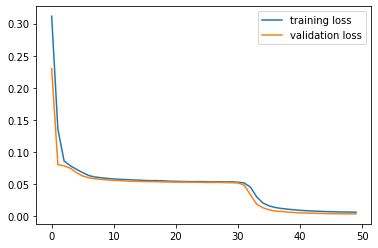

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

(396800, 2048, 2)

In [13]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [14]:
del temp_train

In [15]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [16]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [17]:
del temp_validation

# Predictions

In [18]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

49/49 [==============================] - 60s 1s/step


(396800, 2048, 2)

In [19]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 979ms/step


(39680, 2048, 2)

In [20]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [21]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

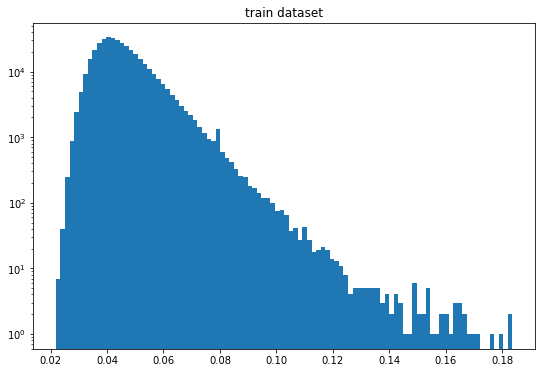

In [22]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [23]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.03966888761304112

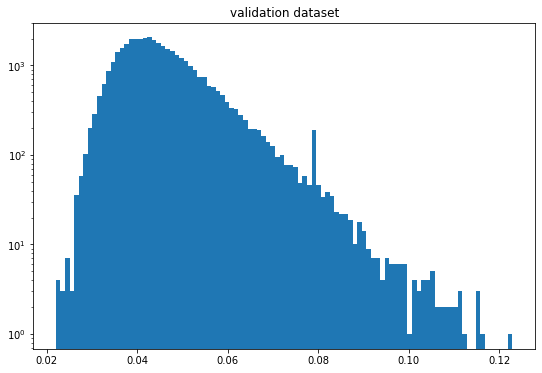

In [24]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [25]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.04222331816362085

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([158633, 238449, 152731, ..., 382985, 171361, 200637])

In [28]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
    
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  158633
MAE:  0.18358054635347332
n_bunches       196
bunch_index     693
bunch_number    129
chunk            23
Name: 6056, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7442/instability_data/07442_Inst_B1H_Q7_20181113_18h41m16s.h5


(47104.0, 49152.0)

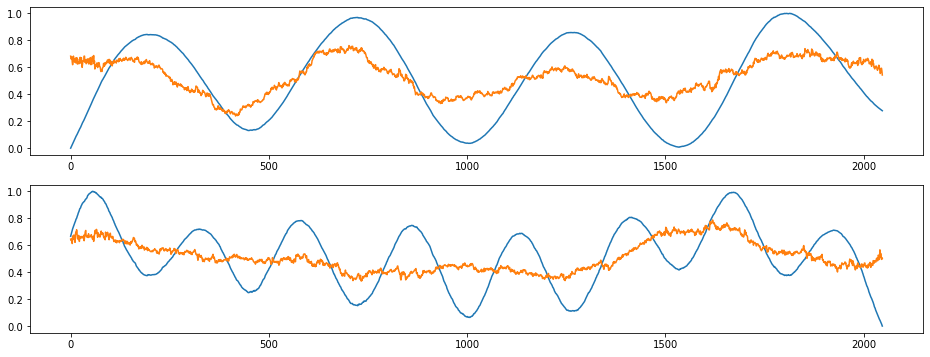

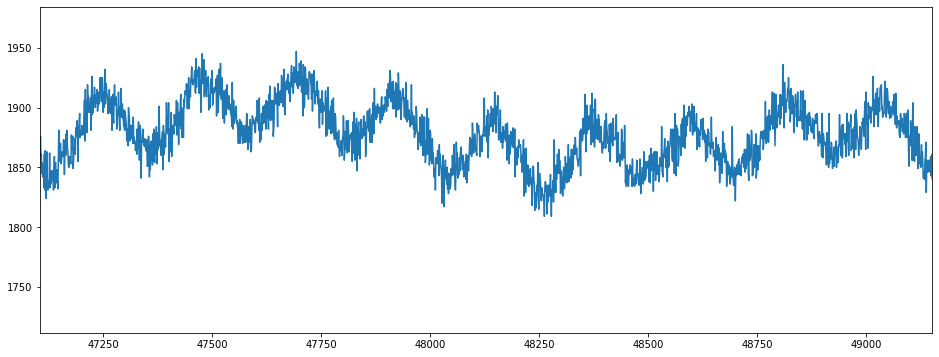

In [29]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk), true_signal.shape[0]*(signal_chunk+1)])

In [30]:
break

SyntaxError: 'break' outside loop (<ipython-input-30-6aaf1f276005>, line 4)

# Top rightmost signals

In [ ]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])
    plt.show()

# Top leftmost signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [ ]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

In [ ]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [ ]:
around_point_indices = np.argsort(np.abs(MAE_train - 6))

In [ ]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)